Implementing Hornshrunk Algorithm


In [74]:
import cv2
import numpy as np
from matplotlib import pyplot as pyplot
from matplotlib import pyplot as plt
import os

In [64]:
# Function to compute the magnitude of optical flow in each 8x8 pixel block
def get_magnitude(u, v):
    scale = 3
    sum = 0.0
    counter = 0.0
    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1], 8):
            counter += 1
            dy = v[i, j] * scale
            dx = u[i, j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            sum += magnitude
    mag_avg = sum / counter
    return mag_avg

In [65]:
# Function to compute image derivatives along x, y, and time
def get_derivatives(img1, img2):
    x_kernel = np.array([[-1, 1], [-1, 1]]) * 0.25
    y_kernel = np.array([[-1, -1], [1, 1]]) * 0.25
    t_kernel = np.ones((2, 2)) * 0.25

    fx = cv2.filter2D(img1, -1, x_kernel) + cv2.filter2D(img2, -1, x_kernel)
    fy = cv2.filter2D(img1, -1, y_kernel) + cv2.filter2D(img2, -1, y_kernel)
    ft = cv2.filter2D(img1, -1, -t_kernel) + cv2.filter2D(img2, -1, t_kernel)

    return [fx, fy, ft]

In [66]:
# Face detection and cropping function
def detect_and_crop_face(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, 1.3, 5)

    if len(faces) == 0:
        raise NameError("No face detected in the image.")

    for (x, y, w, h) in faces:
        face_crop = gray_image[y:y + h, x:x + w]
        return face_crop

    return None

In [67]:
# Function to draw quiver plot for optical flow vectors (One Plot)
def draw_quiver(u, v, beforeImg):
    scale = 3
    ax = pyplot.figure().gca()
    ax.imshow(beforeImg, cmap='gray')

    magnitudeAvg = get_magnitude(u, v)

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1], 8):
            dy = v[i, j] * scale
            dx = u[i, j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            # Draw only significant changes
            if magnitude > magnitudeAvg:
                ax.arrow(j, i, dx, dy, color='red')

    pyplot.draw()
    pyplot.show()

In [68]:
def draw_quiver_only(u, v, beforeImg):
    background = beforeImg
    background[:,:] = 255
    scale = 3
    ax = pyplot.figure().gca()
    magnitudeAvg = get_magnitude(u, v)

    ax.imshow(background, cmap='gray')

    for i in range(0, u.shape[0], 8):
        for j in range(0, u.shape[1], 8):
            dy = v[i, j] * scale
            dx = u[i, j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            # Draw only significant changes
            if magnitude > magnitudeAvg:
                ax.arrow(j, i, dx, dy, color='red')

    pyplot.draw()
    pyplot.show()

In [75]:
# Function to compute Horn-Schunck optical flow with face detection
def computeHS_with_face_detection(image1, image2, alpha, delta, draw = True):
    # Read the images
    beforeImg = cv2.imread(image1)
    afterImg = cv2.imread(image2)

    #Detect and crop the face from both images
    beforeFace = detect_and_crop_face(beforeImg)
    afterFace = detect_and_crop_face(afterImg)

    if beforeFace is None or afterFace is None:
       raise NameError("No face detected in one or both images.")

    beforeFace = beforeFace.astype(float)
    afterFace = afterFace.astype(float)

    # Removing noise
    beforeFace = cv2.GaussianBlur(beforeFace, (5, 5), 0)
    afterFace = cv2.GaussianBlur(afterFace, (5, 5), 0)

    #resize
    beforeFace, afterFace = resize_images(beforeFace, afterFace)

    # Initialize optical flow vectors
    u = np.zeros(beforeFace.shape)
    v = np.zeros(beforeFace.shape)

    # Compute image derivatives
    fx, fy, ft = get_derivatives(beforeFace, afterFace)

    # Horn-Schunck algorithm iterations
    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                           [1 / 6, 0, 1 / 6],
                           [1 / 12, 1 / 6, 1 / 12]], float)
    iter_counter = 0
    while True:
        iter_counter += 1
        u_avg = cv2.filter2D(u, -1, avg_kernel)
        v_avg = cv2.filter2D(v, -1, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        diff = np.linalg.norm(u - prev, 2)
        # Convergence check (at most 300 iterations)
        if diff < delta or iter_counter > 300:
            break

    # Draw the optical flow (quiver plot) for the whole face
    if draw:
        draw_quiver(u, v, beforeFace)

    return [u, v]

In [76]:
def computeHS_without_face_detection(image1, image2, alpha, delta, draw = True):
    # Read the images
    beforeImg = cv2.imread(image1)
    afterImg = cv2.imread(image2)

    beforeFace = beforeImg
    afterFace = afterImg

    # Convert to grayscale
    beforeFace = cv2.cvtColor(beforeFace, cv2.COLOR_BGR2GRAY)
    afterFace = cv2.cvtColor(afterFace, cv2.COLOR_BGR2GRAY)

    beforeFace = beforeFace.astype(float)
    afterFace = afterFace.astype(float)

    # Removing noise
    beforeFace = cv2.GaussianBlur(beforeFace, (5, 5), 0)
    afterFace = cv2.GaussianBlur(afterFace, (5, 5), 0)

    # Resize
    beforeFace, afterFace = resize_images(beforeFace, afterFace)

    # Initialize optical flow vectors
    u = np.zeros(beforeFace.shape)
    v = np.zeros(beforeFace.shape)

    # Compute image derivatives
    fx, fy, ft = get_derivatives(beforeFace, afterFace)

    # Horn-Schunck algorithm iterations
    avg_kernel = np.array([[1 / 12, 1 / 6, 1 / 12],
                           [1 / 6, 0, 1 / 6],
                           [1 / 12, 1 / 6, 1 / 12]], float)
    iter_counter = 0
    while True:
        iter_counter += 1
        u_avg = cv2.filter2D(u, -1, avg_kernel)
        v_avg = cv2.filter2D(v, -1, avg_kernel)
        p = fx * u_avg + fy * v_avg + ft
        d = 4 * alpha**2 + fx**2 + fy**2
        prev = u

        u = u_avg - fx * (p / d)
        v = v_avg - fy * (p / d)

        diff = np.linalg.norm(u - prev, 2)
        # Convergence check (at most 300 iterations)
        if diff < delta or iter_counter > 300:
            break

    # Draw the optical flow (quiver plot) for the whole face
    if draw:
        draw_quiver(u, v, beforeFace)

    return [u, v]


In [44]:
def resize_images(image1, image2):
    # Get the smaller dimensions
    min_height = min(image1.shape[0], image2.shape[0])
    min_width = min(image1.shape[1], image2.shape[1])

    # Resize both images to the smallest dimensions
    resized_img1 = cv2.resize(image1, (min_width, min_height), interpolation=cv2.INTER_AREA)
    resized_img2 = cv2.resize(image2, (min_width, min_height), interpolation=cv2.INTER_AREA)

    return resized_img1, resized_img2

In [45]:
def compute_t_value(u, v):
    # Compute the magnitude of the optical flow at each point
    flow_magnitude = np.sqrt(u**2 + v**2)

    # Find the maximum and minimum flow magnitudes
    max_flow = np.max(flow_magnitude)
    min_flow = np.min(flow_magnitude)

    # Compute the t-value as the difference between max and min flow
    t_value = max_flow - min_flow

    return t_value

In [46]:
def resize_with_aspect_ratio(image, target_width, target_height):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    h, w = gray_image.shape
    # Calculate the scaling factors
    scale_w = target_width / w
    scale_h = target_height / h
    scale = min(scale_w, scale_h)

    # Calculate the new dimensions
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Resize the image
    resized_image = cv2.resize(gray_image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Create a new image with the target size and place the resized image in the center
    new_image = cv2.resize(resized_image, (target_width, target_height), interpolation=cv2.INTER_AREA)

    return new_image

Testing HornSHrunk Algorithm

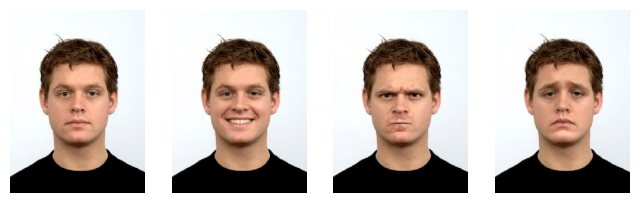

In [77]:
image1 = "Image and Video Data/test.jpg"
image2 = "Image and Video Data/test2.jpg"
image3 = "Image and Video Data/test3.jpg"
image4 = "Image and Video Data/test4.jpg"

plt.figure(figsize=(8,8))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(cv2.imread(image1),cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(cv2.imread(image2),cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(cv2.cvtColor(cv2.imread(image3),cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(cv2.cvtColor(cv2.imread(image4),cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

Neutral to happy


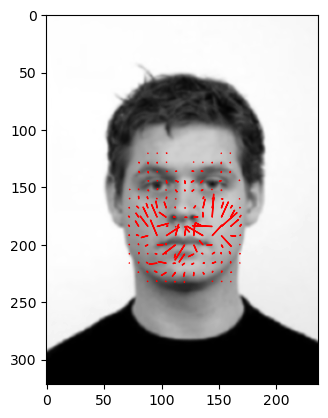

Neutral to angry


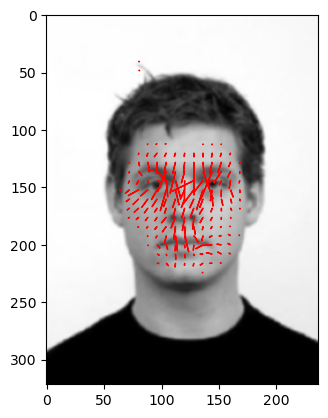

Neutral to sad


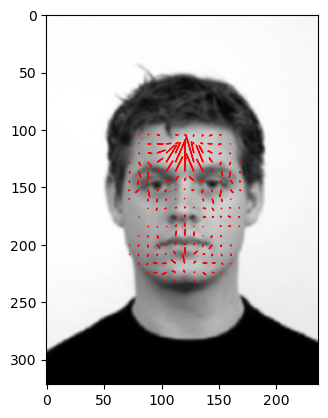

In [78]:
# Neutral to Sad
alpha = 15
delta = 10**-1

print("Neutral to happy")
u1, v1 = computeHS_without_face_detection(image1, image2, alpha, delta)
print("Neutral to angry")
u2, v2 = computeHS_without_face_detection(image1, image3, alpha, delta)
print("Neutral to sad")
u3, v3 = computeHS_without_face_detection(image1, image4, alpha, delta)


Visualizing RGB plot

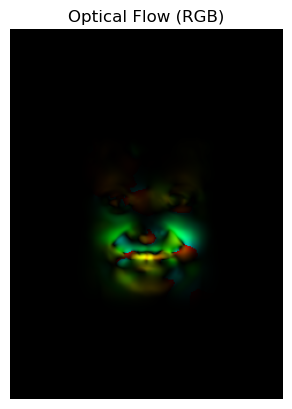

In [79]:
import matplotlib.pyplot as plt

flow_x, flow_y = u1, v1

# Convert the flow to polar coordinates (magnitude and angle)
magnitude, angle = cv2.cartToPolar(flow_x, flow_y)

# Normalize the magnitude to fit within the range [0, 1]
magnitude = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX)

# Convert angle to degrees and map to [0, 180] (for hue in HSV)
angle_deg = angle * 180 / np.pi / 2

# Create an HSV image where:
# - Hue represents direction (angle)
# - Saturation is fixed at 1
# - Value represents magnitude (normalized)
hsv = np.zeros((u1.shape[0], v1.shape[1], 3), dtype=np.float32)
hsv[..., 0] = angle_deg    # Hue (angle of the flow)
hsv[..., 1] = 1            # Saturation (constant full saturation)
hsv[..., 2] = magnitude    # Value (magnitude of the flow)

# Convert the HSV image to RGB for visualization
rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# Show the resulting optical flow visualization
plt.imshow(cv2.cvtColor(rgb_flow, cv2.COLOR_BGR2RGB))  # Convert BGR (OpenCV format) to RGB for correct color display
plt.title('Optical Flow (RGB)')  # Add a title to the plot
plt.axis('off')  # Hide axis

# Display the image
plt.show()

Creating Optical flow Dataset for the Model

1. Loading image files

In [16]:
import os
import cv2
import numpy as np

# Define path to your dataset
dataset_path = 'Image and Video Data/Emotional_faces'

# Define emotions and a structure to store images for processing
target_emotions = ['sadness', 'fear', 'happiness']
data = {'neutral': [], 'sadness': [], 'fear': [], 'happiness': []}

# Iterate through each person's folder
for person_folder in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person_folder)
    if os.path.isdir(person_path):
        # Initialize storage for neutral and target emotion images
        neutral_img_path = None
        emotion_img_paths = {emotion: None for emotion in target_emotions}

        # Find neutral and emotion images
        for img_file in os.listdir(person_path):
            img_path = os.path.join(person_path, img_file)
            if 'neutral' in img_file.lower():
                neutral_img_path = img_path
            else:
                for emotion in target_emotions:
                    if emotion in img_file.lower():
                        emotion_img_paths[emotion] = img_path
                        break

        # Ensure we have a neutral image and images for each target emotion
        if neutral_img_path and all(emotion_img_paths.values()):
            data['neutral'].append((neutral_img_path,neutral_img_path))
            for emotion, img_path in emotion_img_paths.items():
                data[emotion].append((neutral_img_path, img_path))


2. implementing optical flow dataset for images

In [ ]:
optical_flows = []
labels = []
emotion_labels = {'neutral':0, 'sadness': 1, 'fear': 2, 'happiness': 3}  #In here fear means shocked
alpha = 15
delta = 10**-1

# Count total image pairs for progress calculation
total_image_pairs = sum(len(image_pairs) for image_pairs in data.values())
processed_pairs = 0

for emotion, image_pairs in data.items():
    for neutral_img_path, emotion_img_path in image_pairs:
        # Read neutral and emotion images
        neutral_img = neutral_img_path
        emotion_img = emotion_img_path

        # Compute optical flow between neutral and emotional image
        
        u, v = computeHS_without_face_detection(neutral_img, emotion_img, alpha, delta, draw = False)
        
        # Resize as needed for CNN
        u_resized = cv2.resize(u, (224, 224))
        v_resized = cv2.resize(v, (224, 224))

        flow = np.stack((u_resized,  v_resized), axis=-1)

        # Append flow image and label
        optical_flows.append(flow)
        labels.append(emotion_labels[emotion])

        processed_pairs += 1
        progress = (processed_pairs / total_image_pairs) * 100
        print(f'Progress: {progress:.2f}% complete', end='\r')

    #print the progress
    print(f'Processed {emotion} images')

print("\nProcessing complete.")
      
# Convert lists to arrays for input into CNN
X = np.array(optical_flows)
y = np.array(labels)

Processed neutral imagese
Processed sadness imagese
Processed fear imageslete
Processed happiness images

Processing complete.


In [19]:
np.save('optical_flows.npy', X)
np.save('labels.npy', y)

Testing the Model for Images

In [80]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('emotion_classification_model.h5')
model.summary()  # Display the model's architecture


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_1 (InputLayer)            │ (None, 224, 224, 2)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_conv1 (Conv2D)            │ (None, 224, 224, 64)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,294 (56.38 MB)

 Trainable params: 67,396 (263.27 KB)

 Non-trainable params: 14,712,896 (56.13 MB)

 Optimizer params: 2 (12.00 B)

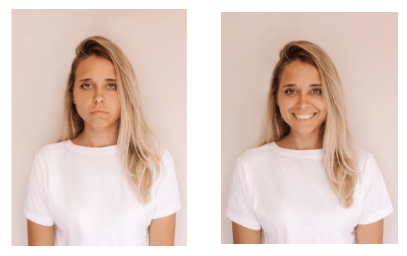

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Emotion: happiness


In [81]:
image1 = "Image and Video Data/neutral.png"

image2 = "Image and Video Data/happy.png"

u, v = computeHS_without_face_detection(image1, image2, alpha, delta, draw = False)

u_resized = cv2.resize(u, (224, 224))
v_resized = cv2.resize(v, (224, 224))

flow = np.stack((u_resized,  v_resized), axis=-1)

flow = np.expand_dims(flow, axis=0)  # Reshape to (1, 224, 224, 2)

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(cv2.imread(image1),cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cv2.imread(image2),cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()
           
emotion_labels = {0: 'neutral', 1: 'sadness', 2: 'shocked', 3: 'happiness'}

prediction = model.predict(flow)
predicted_class = np.argmax(prediction)

predicted_emotion = emotion_labels[predicted_class]
print(f'Predicted Emotion: {predicted_emotion}')
